<a href="https://colab.research.google.com/github/ThodupunooriSaiManish/Machine_Learning/blob/main/ML_Internal_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_breast_cancer, load_diabetes
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, mutual_info_regression, chi2, f_classif, f_regression, SelectKBest
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Load datasets
datasets = {
    "Iris": load_iris(as_frame=True),
    "Breast Cancer": load_breast_cancer(as_frame=True),
    "Diabetes": load_diabetes(as_frame=True)
}

for name, data in datasets.items():
    print(f"\n=== {name} Dataset ===")
    X, y = data.data, data.target

    # 1. Constant features
    X1 = VarianceThreshold(0).fit_transform(X)
    print("Const:", X1.shape, end=" | ")

    # 2. Quasi-constant features (safe check)
    try:
        X2 = VarianceThreshold(0.01).fit_transform(X)
        print("Quasi:", X2.shape)
    except ValueError:
        print("Quasi: no features dropped")

    # 3. Duplicate features
    X3 = X.T.drop_duplicates().T
    print("No Duplicates:", X3.shape)

    # 4. Correlation filter
    corr = X.corr().abs()
    drop = [c for c in corr if any(corr[c] > 0.9)]
    X4 = X.drop(columns=drop)
    print("After Corr:", X4.shape)

    # 5. Mutual Information
    mi = mutual_info_regression(X, y) if name=="Diabetes" else mutual_info_classif(X, y)
    print("MI:", mi[:5], "...")  # show first 5

    # 6. Chi-Square (only classification)
    if name!="Diabetes":
        chi_vals, _ = chi2(X.abs(), y)
        print("Chi2:", chi_vals[:5], "...")

    # 7. ANOVA
    func = f_regression if name=="Diabetes" else f_classif
    k = min(5, X.shape[1])  # avoid warning
    X5 = SelectKBest(func, k=k).fit_transform(X, y)
    print("ANOVA:", X5.shape)

    # 8. ROC-AUC or MSE (only 3 features for demo)
    for col in X.columns[:3]:
        Xtr, Xte, ytr, yte = train_test_split(X[[col]], y, test_size=0.3, random_state=42)
        if name=="Diabetes":
            mse = mean_squared_error(yte, LinearRegression().fit(Xtr,ytr).predict(Xte))
            print(f"{col}: MSE={mse:.4f}")
        else:
            prob = LogisticRegression(max_iter=1000).fit(Xtr,ytr).predict_proba(Xte)[:,1]
            auc = roc_auc_score((yte>0).astype(int), prob)
            print(f"{col}: ROC-AUC={auc:.4f}")



=== Iris Dataset ===
Const: (150, 4) | Quasi: (150, 4)
No Duplicates: (150, 4)
After Corr: (150, 0)
MI: [0.5130965  0.32159614 0.98555301 0.98798784] ...
Chi2: [ 10.81782088   3.7107283  116.31261309  67.0483602 ] ...
ANOVA: (150, 4)
sepal length (cm): ROC-AUC=0.6741
sepal width (cm): ROC-AUC=0.8877
petal length (cm): ROC-AUC=0.8785

=== Breast Cancer Dataset ===
Const: (569, 30) | Quasi: (569, 14)
No Duplicates: (569, 30)
After Corr: (569, 0)
MI: [0.36863134 0.09587126 0.40306909 0.36071749 0.08300286] ...
Chi2: [2.66104917e+02 9.38975081e+01 2.01110286e+03 5.39916559e+04
 1.49899264e-01] ...
ANOVA: (569, 5)
mean radius: ROC-AUC=0.9686
mean texture: ROC-AUC=0.7779
mean perimeter: ROC-AUC=0.9759

=== Diabetes Dataset ===
Const: (442, 10) | Quasi: no features dropped
No Duplicates: (442, 10)
After Corr: (442, 0)
MI: [0.00088713 0.02826869 0.17362077 0.05609104 0.06659205] ...
ANOVA: (442, 5)
age: MSE=5256.0929
sex: MSE=5427.2587
bmi: MSE=3884.9367


In [ ]:
# --------------------------
# Wrapper Feature Selection
# --------------------------

# Required imports
import pandas as pd
from sklearn.datasets import load_iris, load_breast_cancer, load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# Load datasets
datasets = {
    "Iris": load_iris(as_frame=True),
    "Breast Cancer": load_breast_cancer(as_frame=True),
    "Diabetes": load_diabetes(as_frame=True)
}

# Iterate over datasets
for name, data in datasets.items():
    print(f"\n=== {name} Dataset ===")
    X, y = data.data, data.target

    # Scale features for faster convergence
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Choose model type
    model = LinearRegression() if name=="Diabetes" else LogisticRegression(max_iter=5000)

    # --------------------------
    # 1. Forward Selection
    # --------------------------
    fwd = SFS(model, k_features=3, forward=True, floating=False,
              scoring='r2' if name=="Diabetes" else 'accuracy', cv=3)
    fwd.fit(X_scaled, y)
    print("Forward Selection:", fwd.k_feature_names_)

    # --------------------------
    # 2. Backward Selection
    # --------------------------
    bwd = SFS(model, k_features=3, forward=False, floating=False,
              scoring='r2' if name=="Diabetes" else 'accuracy', cv=3)
    bwd.fit(X_scaled, y)
    print("Backward Selection:", bwd.k_feature_names_)

    # --------------------------
    # 3. Exhaustive Search (only small datasets)
    # --------------------------
    if X.shape[1] <= 10:
        efs = EFS(model, min_features=2, max_features=3,
                  scoring='r2' if name=="Diabetes" else 'accuracy', cv=3)
        efs.fit(X_scaled, y)
        print("Exhaustive Search Best:", efs.best_idx_)
    else:
        print("Exhaustive Search skipped (too many features)")

    # --------------------------
    # 4. Recursive Feature Elimination (RFE)
    # --------------------------
    rfe = RFE(model, n_features_to_select=3)
    rfe.fit(X_scaled, y)
    selected = [col for col, keep in zip(X.columns, rfe.support_) if keep]
    print("RFE Selected:", selected)


=== Iris Dataset ===
Forward Selection: ('0', '2', '3')
Backward Selection: ('0', '2', '3')


Features: 10/10

Exhaustive Search Best: (2, 3)
RFE Selected: ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

=== Breast Cancer Dataset ===
Forward Selection: ('21', '22', '24')
Backward Selection: ('0', '21', '24')
Exhaustive Search skipped (too many features)
RFE Selected: ['worst radius', 'worst area', 'worst concave points']

=== Diabetes Dataset ===
Forward Selection: ('2', '3', '8')
Backward Selection: ('2', '3', '8')


Features: 165/165

Exhaustive Search Best: (2, 3, 8)
RFE Selected: ['bmi', 's1', 's5']


In [ ]:
#3
# --------------------------
# Embedded Feature Selection
# --------------------------

# Required imports
import pandas as pd
from sklearn.datasets import load_iris, load_breast_cancer, load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import numpy as np

# Load datasets
datasets = {
    "Iris": load_iris(as_frame=True),
    "Breast Cancer": load_breast_cancer(as_frame=True),
    "Diabetes": load_diabetes(as_frame=True)
}

for name, data in datasets.items():
    print(f"\n=== {name} Dataset ===")
    X, y = data.data, data.target

    # Scale features (important for regularization)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --------------------------
    # 1. L1 Regularization (LASSO)
    # --------------------------
    if name == "Diabetes":
        lasso = Lasso(alpha=0.1).fit(X_scaled, y)
        selected_l1 = X.columns[np.abs(lasso.coef_)>1e-4]
        print("LASSO Selected Features:", selected_l1.tolist())
    else:
        l1 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=5000)
        l1.fit(X_scaled, y)
        selected_l1 = X.columns[np.abs(l1.coef_).sum(axis=0)>1e-4]
        print("L1 Logistic Selected Features:", selected_l1.tolist())

    # --------------------------
    # 2. L2 Regularization (Ridge)
    # --------------------------
    if name == "Diabetes":
        ridge = Ridge(alpha=1.0).fit(X_scaled, y)
        print("Ridge Coefficients:", ridge.coef_)
    else:
        l2 = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, max_iter=5000)
        l2.fit(X_scaled, y)
        print("L2 Logistic Coefficients Sum:", np.sum(np.abs(l2.coef_), axis=0))

    # --------------------------
    # 3. Elastic Net
    # --------------------------
    if name == "Diabetes":
        enet = ElasticNet(alpha=0.1, l1_ratio=0.5).fit(X_scaled, y)
        selected_enet = X.columns[np.abs(enet.coef_)>1e-4]
        print("Elastic Net Selected Features:", selected_enet.tolist())

    # --------------------------
    # 4. Other ML Methods (Tree/SVM)
    # --------------------------
    if name == "Diabetes":
        # Use DecisionTreeRegressor or RandomForestRegressor if you want regression
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.tree import DecisionTreeRegressor

        dt = DecisionTreeRegressor().fit(X_scaled, y)
        rf = RandomForestRegressor(n_estimators=100).fit(X_scaled, y)
        print("Decision Tree Feature Importance:", dt.feature_importances_)
        print("Random Forest Feature Importance:", rf.feature_importances_)
    else:
        dt = DecisionTreeClassifier().fit(X_scaled, y)
        rf = RandomForestClassifier(n_estimators=100).fit(X_scaled, y)
        svc = LinearSVC(penalty='l1', dual=False, max_iter=5000).fit(X_scaled, y)
        print("Decision Tree Importance:", dt.feature_importances_)
        print("Random Forest Importance:", rf.feature_importances_)
        print("Linear SVC Importance:", np.abs(svc.coef_).sum(axis=0))


=== Iris Dataset ===
L1 Logistic Selected Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
L2 Logistic Coefficients Sum: [0.95932744 2.79999635 4.3383141  5.12579351]
Decision Tree Importance: [0.01333333 0.01333333 0.05072262 0.92261071]
Random Forest Importance: [0.10061115 0.02405513 0.44232311 0.43301061]
Linear SVC Importance: [0.32317855 1.09429101 3.71770021 2.97770126]

=== Breast Cancer Dataset ===
L1 Logistic Selected Features: ['mean concavity', 'mean concave points', 'mean fractal dimension', 'radius error', 'texture error', 'smoothness error', 'compactness error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst area', 'worst smoothness', 'worst concavity', 'worst concave points', 'worst symmetry']
L2 Logistic Coefficients Sum: [0.35372245 0.3850941  0.34237238 0.44138446 0.15523716 0.5681635
 0.8685186  0.96811443 0.07328189 0.31122062 1.29527365 0.26995006
 0.6662383  1.02954508 0.2812678  0.74241788 0.113522

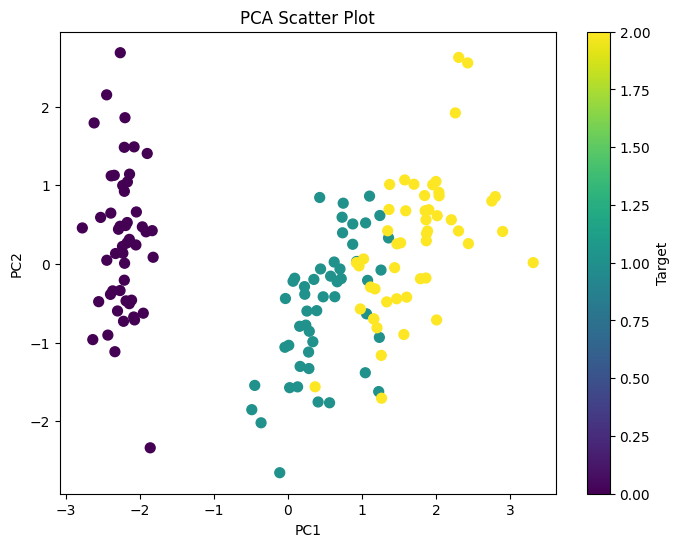


Feature loadings for PC1 and PC2:
                        PC1       PC2
sepal length (cm)  0.521066  0.377418
sepal width (cm)  -0.269347  0.923296
petal length (cm)  0.580413  0.024492
petal width (cm)   0.564857  0.066942

Most important variables for PC1:
petal length (cm)    0.580413
petal width (cm)     0.564857
sepal length (cm)    0.521066
Name: PC1, dtype: float64

Most important variables for PC2:
sepal width (cm)     0.923296
sepal length (cm)    0.377418
petal width (cm)     0.066942
Name: PC2, dtype: float64

Variance explained by PC1: 72.96%
Variance explained by PC2: 22.85%

Number of PCs explaining >=80% variance: 2


In [ ]:
# --------------------------
# PCA Analysis Program
# --------------------------

# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_breast_cancer, load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load any dataset (example: Iris, Breast Cancer, Diabetes)
dataset = load_iris(as_frame=True)
X = dataset.data
y = dataset.target
feature_names = X.columns

# --------------------------
# 4.a Standardize the variables
# --------------------------
# PCA is affected by scale, so standardization ensures each variable contributes equally.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------
# 4.b Apply PCA
# --------------------------
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Scatter plot using PC1 and PC2
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot')
plt.colorbar(label='Target')
plt.show()

# --------------------------
# 4.c Identify most important variables for PC1 and PC2
# --------------------------
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(X.shape[1])],
                        index=feature_names)

print("\nFeature loadings for PC1 and PC2:")
print(loadings[['PC1','PC2']])

print("\nMost important variables for PC1:")
print(loadings['PC1'].abs().sort_values(ascending=False).head(3))

print("\nMost important variables for PC2:")
print(loadings['PC2'].abs().sort_values(ascending=False).head(3))

# Explanation:
# The higher the absolute value of a feature's loading, the more it contributes to that PC.

# --------------------------
# 4.d Variance explained by PC1 and PC2
# --------------------------
explained_variance = pca.explained_variance_ratio_
print(f"\nVariance explained by PC1: {explained_variance[0]*100:.2f}%")
print(f"Variance explained by PC2: {explained_variance[1]*100:.2f}%")

# --------------------------
# 4.e Number of PCs explaining >80% of total variance
# --------------------------
cumulative_variance = np.cumsum(explained_variance)
num_pcs_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"\nNumber of PCs explaining >=80% variance: {num_pcs_80}")

   Size_sqft    Price
0       1360  22435.0
1       1794  23233.2
2       1630  46560.0
3       1595  35900.5
4       2138  25899.4

Intercept (b0): 35980.74317646303
Slope (b1)  : 0.6614842378409155

Interpretation: For every 1 sqft increase, the house price changes by 0.66 units.

Evaluation Metrics:
MSE  : 103746042.09
MAE  : 8962.44
RMSE : 10185.58


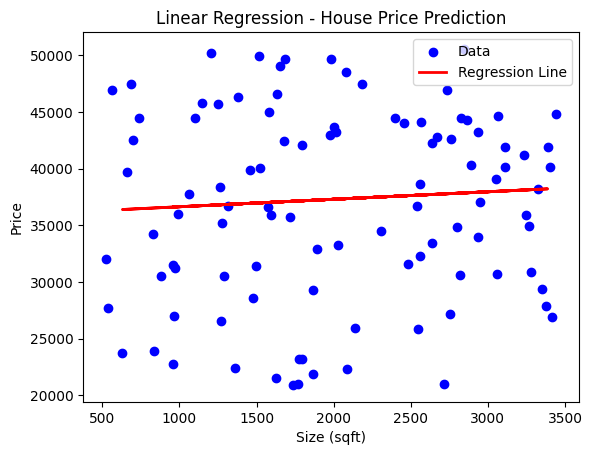

In [ ]:
# --------------------------
# Linear Regression - House Price Prediction
# --------------------------

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------------------------
# 1. Load or create dataset
# --------------------------
# Example: synthetic house prices dataset
np.random.seed(42)
# Features: size in square feet
X = np.random.randint(500, 3500, size=(100,1))
# Target: price in thousands, roughly correlated with size
y = X.flatten()*0.3 + np.random.randint(20000, 50000, size=100)

# Convert to DataFrame for clarity
data = pd.DataFrame({'Size_sqft': X.flatten(), 'Price': y})
print(data.head())

# --------------------------
# 2. Split dataset
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------
# 3. Train Linear Regression Model
# --------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# --------------------------
# 4. Display intercept and slope
# --------------------------
print("\nIntercept (b0):", model.intercept_)
print("Slope (b1)  :", model.coef_[0])
print(f"\nInterpretation: For every 1 sqft increase, the house price changes by {model.coef_[0]:.2f} units.")

# --------------------------
# 5. Predict on test set
# --------------------------
y_pred = model.predict(X_test)

# --------------------------
# 6. Compute metrics
# --------------------------
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\nEvaluation Metrics:")
print(f"MSE  : {mse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

# --------------------------
# 7. Plot regression line
# --------------------------
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Size (sqft)')
plt.ylabel('Price')
plt.title('Linear Regression - House Price Prediction')
plt.legend()
plt.show()

   YearsExperience   Salary
0              1.1  39343.0
1              1.3  46205.0
2              1.5  37731.0
3              2.0  43525.0
4              2.2  39891.0

Intercept (b0): 25321.583011776813
Slope (b1)    : 9423.815323030976

Interpretation: For every 1 year increase in experience, salary changes by 9423.82 units.

Evaluation Metrics:
MSE  : 49830096.86
MAE  : 6286.45
RMSE : 7059.04


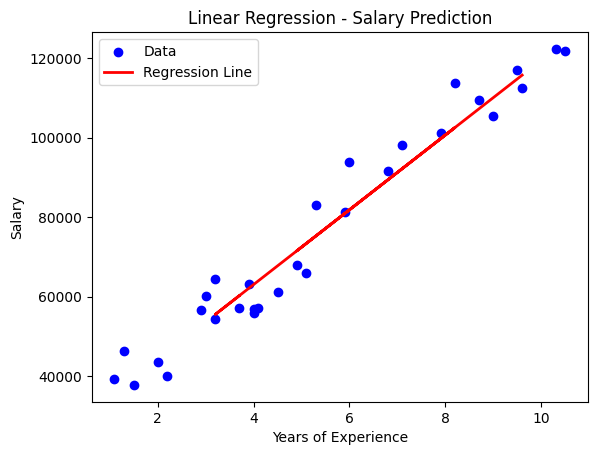

In [ ]:
# --------------------------
# Linear Regression - Salary Prediction
# --------------------------

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------------------------
# 1. Load Salary Data
# --------------------------
# Replace the path with your CSV file location
data = pd.read_csv('/content/drive/MyDrive/ML_Lab/Datasets/Salary_Data.csv')
print(data.head())

# Independent variable (X) - Years of Experience
X = data[['YearsExperience']].values
# Dependent variable (y) - Salary
y = data['Salary'].values

# --------------------------
# 2. Split into train and test sets
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------
# 3. Train Linear Regression
# --------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# --------------------------
# 4. Display intercept and slope
# --------------------------
print("\nIntercept (b0):", model.intercept_)
print("Slope (b1)    :", model.coef_[0])
print(f"\nInterpretation: For every 1 year increase in experience, salary changes by {model.coef_[0]:.2f} units.")

# --------------------------
# 5. Predict on test set
# --------------------------
y_pred = model.predict(X_test)

# --------------------------
# 6. Evaluation Metrics
# --------------------------
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\nEvaluation Metrics:")
print(f"MSE  : {mse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

# --------------------------
# 7. Plot Regression Line
# --------------------------
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.title('Linear Regression - Salary Prediction')
plt.legend()
plt.show()


In [ ]:
# --------------------------
# Multiple Linear Regression - Weight Reduction
# --------------------------

# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Sample dataset (you can replace with actual CSV)
np.random.seed(42)
data = pd.DataFrame({
    'Age': np.random.randint(20, 50, 50),
    'Height': np.random.randint(150, 190, 50),
    'Weight': np.random.randint(60, 100, 50),
    'TimeOnExercise': np.random.randint(1, 10, 50)
})

# Dependent variable: WeightReduction (synthetic)
data['WeightReduction'] = 0.2*data['Age'] - 0.1*data['Height'] + 0.5*data['Weight'] + 1.5*data['TimeOnExercise'] + np.random.randint(-5,5,50)

# Features and target
X = data[['Age', 'Height', 'Weight', 'TimeOnExercise']]
y = data['WeightReduction']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients
print("Intercept:", model.intercept_)
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nCoefficients:\n", coeff_df)

# Predict
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"\nMSE: {mse:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Intercept: -0.6788311832814173

Coefficients:
                 Coefficient
Age                0.212664
Height            -0.111175
Weight             0.524210
TimeOnExercise     1.305249

MSE: 9.09, MAE: 2.78, RMSE: 3.02


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/ML_Lab/Datasets/house_price_train.csv')

# Select features (independent variables) and target
X = data[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'GarageCars']]
y = data['SalePrice']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Multiple Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Display intercept and coefficients
print("Intercept:", model.intercept_)
print("Coefficients:")
coef_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coef_df)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"\nMSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Intercept: -694533.3581039772
Coefficients:
              Coefficient
OverallQual  20392.513001
GrLivArea       48.809801
TotalBsmtSF     25.365319
YearBuilt      315.923350
GarageCars   15144.237204

MSE: 1581119650.39
MAE: 25414.73
RMSE: 39763.30


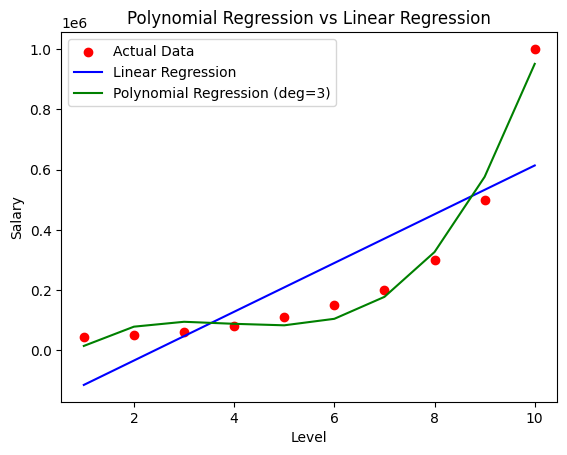

Polynomial Regression MSE: 1515662004.66
Polynomial Regression R2 Score: 0.98


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset (replace path if needed)
data = pd.read_csv('/content/drive/MyDrive/ML_Lab/Datasets/Position_Salaries.csv')
X = data[['Level']].values   # Independent variable
y = data['Salary'].values    # Dependent variable

# Fit Linear Regression (for comparison)
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Fit Polynomial Regression (degree 3)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)

# Predict using both models
y_pred_lin = lin_reg.predict(X)
y_pred_poly = poly_reg.predict(X_poly)

# Plot results
plt.scatter(X, y, color='red', label='Actual Data')
plt.plot(X, y_pred_lin, color='blue', label='Linear Regression')
plt.plot(X, y_pred_poly, color='green', label='Polynomial Regression (deg=3)')
plt.xlabel('Level')
plt.ylabel('Salary')
plt.title('Polynomial Regression vs Linear Regression')
plt.legend()
plt.show()

# Evaluation
mse_poly = mean_squared_error(y, y_pred_poly)
r2_poly = r2_score(y, y_pred_poly)
print(f"Polynomial Regression MSE: {mse_poly:.2f}")
print(f"Polynomial Regression R2 Score: {r2_poly:.2f}")


In [ ]:
# 1. Imports
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 2. Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

# 3. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Train Logistic Regression model
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# 5. Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # probabilities for ROC-AUC

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

print("Confusion Matrix:")
print(cm)

# 7. Built-in metrics
print("\nBuilt-in Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# 8. Manual calculations from confusion matrix
accuracy_manual = (TP + TN) / (TP + TN + FP + FN)
precision_manual = TP / (TP + FP) if (TP + FP) != 0 else 0
recall_manual = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_manual = 2 * (precision_manual * recall_manual) / (precision_manual + recall_manual) if (precision_manual + recall_manual) != 0 else 0

print("\nManual Calculations:")
print("Accuracy:", accuracy_manual)
print("Precision:", precision_manual)
print("Recall:", recall_manual)
print("F1 Score:", f1_manual)


Confusion Matrix:
[[ 61   2]
 [  2 106]]

Built-in Metrics:
Accuracy: 0.9766081871345029
Precision: 0.9814814814814815
Recall: 0.9814814814814815
F1 Score: 0.9814814814814815
ROC-AUC: 0.9976484420928865

Manual Calculations:
Accuracy: 0.9766081871345029
Precision: 0.9814814814814815
Recall: 0.9814814814814815
F1 Score: 0.9814814814814815


Learning rate: 0.0001
Intercept (theta0): 17218.57, Slope (theta1): 5355.84
Final MSE: 32542978230.18

Learning rate: 0.001
Intercept (theta0): 114430.62, Slope (theta1): 35593.70
Final MSE: 8008035130.53

Learning rate: 0.01
Intercept (theta0): 180913.77, Slope (theta1): 56273.31
Final MSE: 3139843272.58



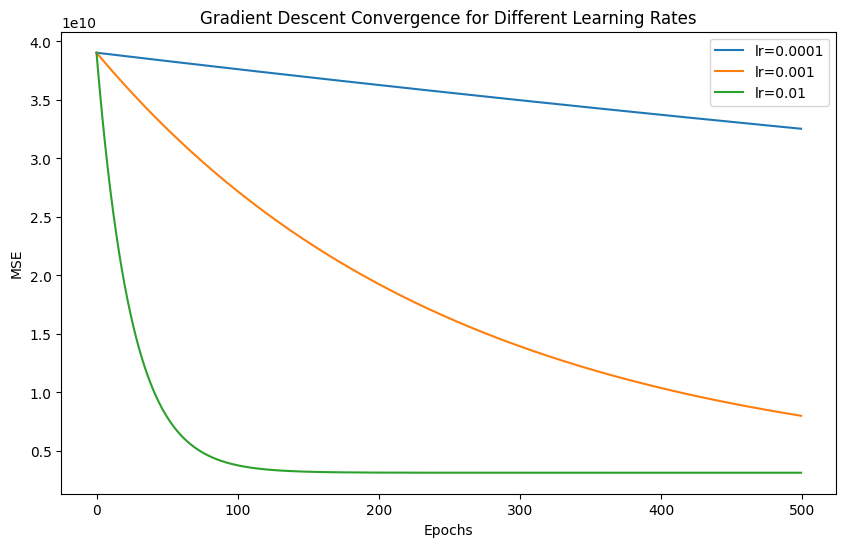

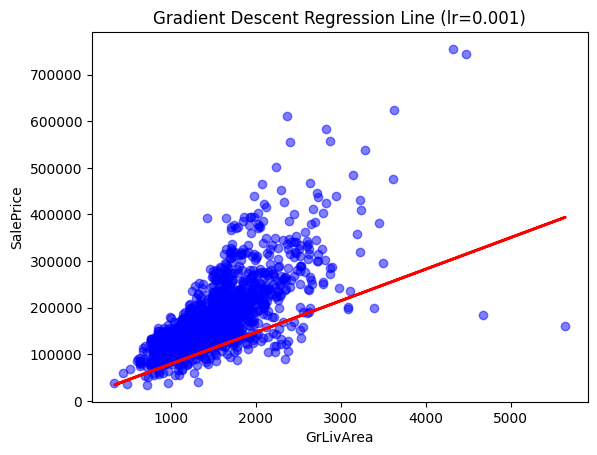

In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 2. Load dataset (replace path with your CSV location)
data = pd.read_csv('/content/drive/MyDrive/ML_Lab/Datasets/house_price_train.csv')

# Select features
X = data[['GrLivArea']].values
y = data['SalePrice'].values

# 3. Standardize X for faster convergence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Add bias term (column of 1s)
X_b = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]

# 5. Gradient Descent function
def gradient_descent(X, y, lr=0.01, epochs=1000):
    m = len(y)
    theta = np.zeros(X.shape[1])  # initialize parameters
    cost_history = []

    for i in range(epochs):
        y_pred = X.dot(theta)
        error = y_pred - y
        gradients = (2/m) * X.T.dot(error)
        theta = theta - lr * gradients
        cost = (1/m) * np.sum(error**2)
        cost_history.append(cost)

    return theta, cost_history

# 6. Run Gradient Descent with different learning rates
learning_rates = [0.0001, 0.001, 0.01]  # smaller because SalePrice scale is large
epochs = 500

plt.figure(figsize=(10,6))

for lr in learning_rates:
    theta, cost_history = gradient_descent(X_b, y, lr=lr, epochs=epochs)
    print(f"Learning rate: {lr}")
    print(f"Intercept (theta0): {theta[0]:.2f}, Slope (theta1): {theta[1]:.2f}")
    print(f"Final MSE: {cost_history[-1]:.2f}\n")

    plt.plot(range(epochs), cost_history, label=f'lr={lr}')

plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Gradient Descent Convergence for Different Learning Rates")
plt.legend()
plt.show()

# 7. Plot Regression Line for best learning rate
best_lr = 0.001
theta_best, _ = gradient_descent(X_b, y, lr=best_lr, epochs=epochs)

plt.scatter(X, y, color='blue', alpha=0.5)
plt.plot(X, X_b.dot(theta_best), color='red', linewidth=2)
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title(f"Gradient Descent Regression Line (lr={best_lr})")
plt.show()

Linear Regression MSE: 8.740318101044503
LASSO Regression MSE: 8.756568203046118
Ridge Regression MSE: 8.740418479631996
Linear Regression Coefficients: [ 0.          0.73574104 -1.15332181  0.53632319]
LASSO Coefficients: [ 0.          0.55425854 -1.14474438  0.56343043]
Ridge Coefficients: [ 0.          0.72220167 -1.15213561  0.5383793 ]


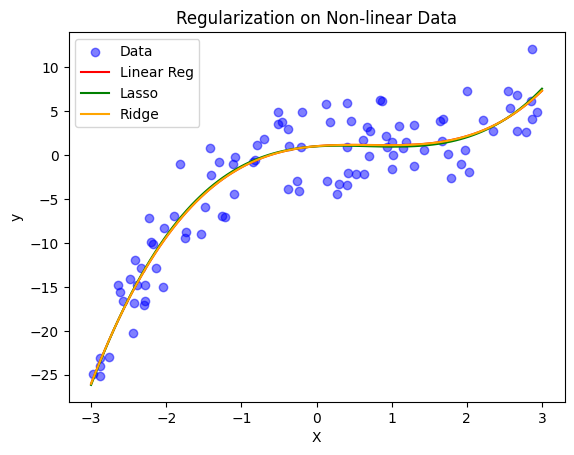

In [ ]:
# 1. Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# 2. Generate non-linear data
np.random.seed(0)
X = np.random.uniform(-3, 3, 100).reshape(-1, 1)
y = 0.5 * X**3 - X**2 + X + np.random.normal(0, 3, X.shape)  # shape (100,1)
y = y.ravel()  # convert to 1D

# 3. Polynomial Features (degree 3)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

# 4. Linear Regression
lr = LinearRegression()
lr.fit(X_poly, y)
y_pred_lr = lr.predict(X_poly)

# 5. LASSO Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_poly, y)
y_pred_lasso = lasso.predict(X_poly)

# 6. RIDGE Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_poly, y)
y_pred_ridge = ridge.predict(X_poly)

# 7. Metrics (MSE)
print("Linear Regression MSE:", mean_squared_error(y, y_pred_lr))
print("LASSO Regression MSE:", mean_squared_error(y, y_pred_lasso))
print("Ridge Regression MSE:", mean_squared_error(y, y_pred_ridge))

# 8. Coefficients
print("Linear Regression Coefficients:", lr.coef_)
print("LASSO Coefficients:", lasso.coef_)
print("Ridge Coefficients:", ridge.coef_)

# 9. Plot
plt.scatter(X.ravel(), y, color='blue', alpha=0.5, label='Data')  # flatten X
X_plot = np.linspace(-3, 3, 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)

plt.plot(X_plot, lr.predict(X_plot_poly), color='red', label='Linear Reg')
plt.plot(X_plot, lasso.predict(X_plot_poly), color='green', label='Lasso')
plt.plot(X_plot, ridge.predict(X_plot_poly), color='orange', label='Ridge')

plt.xlabel("X")
plt.ylabel("y")
plt.title("Regularization on Non-linear Data")
plt.legend()
plt.show()


MSE: 3552.701313323753
R² Score: 0.3294451571119206


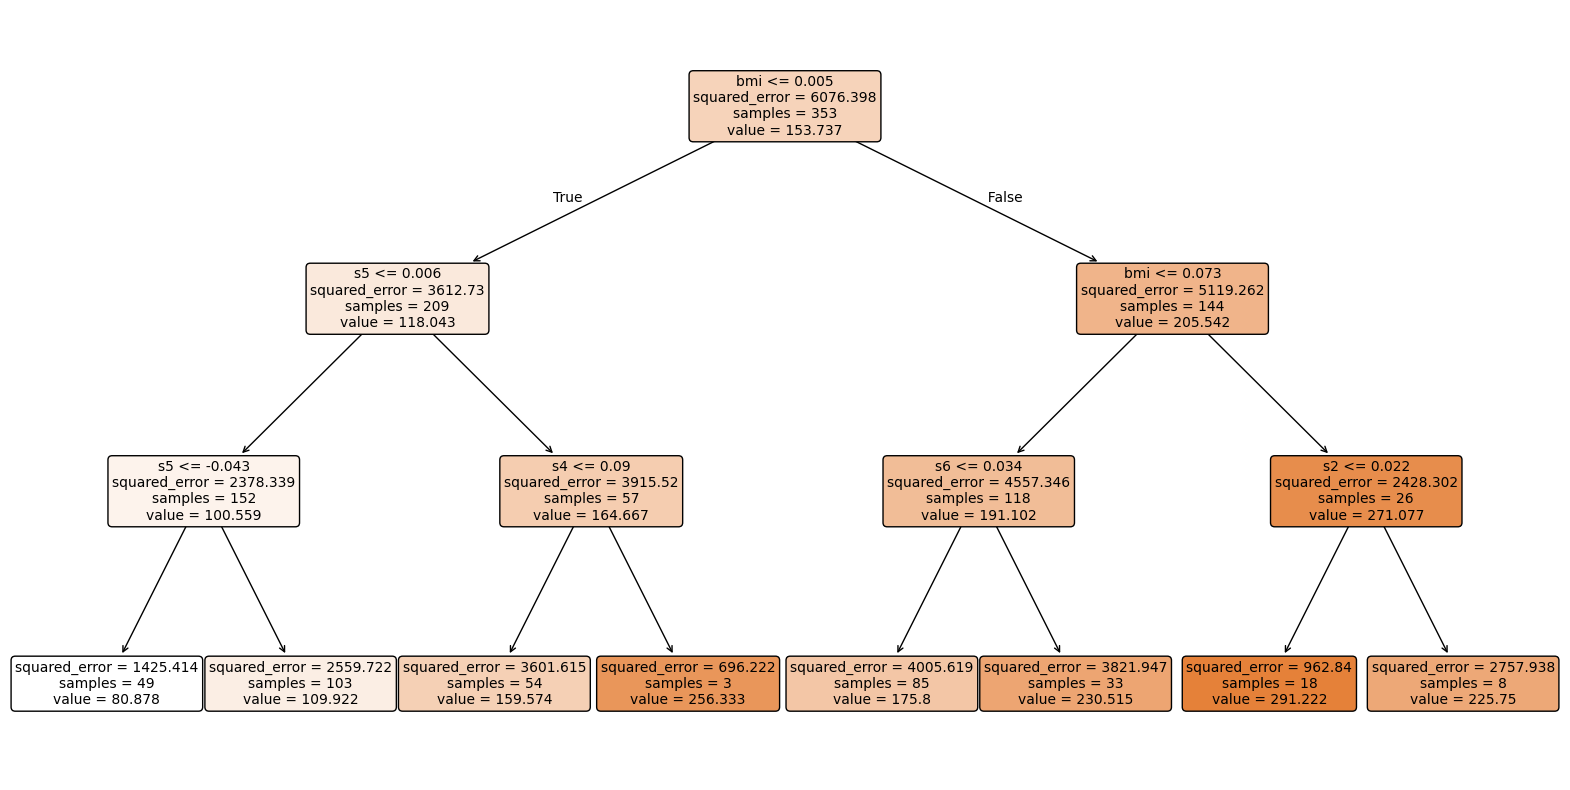

In [ ]:
# 1. Imports
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

# 2. Load dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# 3. Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Decision Tree Model
tree = DecisionTreeRegressor(max_depth=3, random_state=42)  # depth limited for clarity
tree.fit(X_train, y_train)

# 5. Predictions
y_pred = tree.predict(X_test)

# 6. Metrics
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# 7. Display Tree Structure
plt.figure(figsize=(20,10))
plot_tree(
    tree,
    feature_names=diabetes.feature_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/ML_Lab/Datasets/loan_data.csv")  # update path

# Fix missing values
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].fillna(data[col].mode()[0])
    else:
        data[col] = data[col].fillna(data[col].median())

# Encode categorical features
data_encoded = pd.get_dummies(data, drop_first=True)

# ✅ Target column is 'loan_status'
target_col = "loan_status"

X = data_encoded.drop(target_col, axis=1)
y = data_encoded[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8064444444444444
Confusion Matrix:
 [[10006   487]
 [ 2126   881]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88     10493
           1       0.64      0.29      0.40      3007

    accuracy                           0.81     13500
   macro avg       0.73      0.62      0.64     13500
weighted avg       0.78      0.81      0.78     13500



In [ ]:
#14
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Load dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Standardize features (very important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Train SVC model
svc_model = SVC(kernel='linear', random_state=42)  # you can try 'rbf', 'poly' also
svc_model.fit(X_train, y_train)

# 5. Predictions
y_pred = svc_model.predict(X_test)

# 6. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9824561403508771

Confusion Matrix:
 [[ 62   2]
 [  1 106]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98        64
           1       0.98      0.99      0.99       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



In [ ]:
#15
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Load dataset
iris = load_iris()
X = iris.data
y = iris.target

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Standardize features (important for distance-based algorithms like KNN)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Train KNN model (you can change n_neighbors = 3, 5, 7...)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# 5. Predictions
y_pred = knn.predict(X_test)

# 6. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9111111111111111

Confusion Matrix:
 [[15  0  0]
 [ 0 15  0]
 [ 0  4 11]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.79      1.00      0.88        15
           2       1.00      0.73      0.85        15

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45



#Internal_2